In [299]:
import sd4py
import numpy as np
import pandas as pd

In [300]:
df2 = pd.DataFrame(
    {
        "A": pd.Series(np.random.randn(1000), dtype="float16"),
        "B": pd.Series(np.random.randn(1000)),
        "C": pd.Series(np.array(np.random.randint(0, 255, 1000, dtype="uint8"))),
        "D": np.random.choice(["foo","bar"], 1000),
        "E": pd.date_range("2018-01-01", periods=1000, freq="H"),
        "G": np.random.choice([1,5,10], 1000),
        "H": [pd.Timedelta(hours=x) for x in np.random.choice(np.arange(1,10),1000)],
        "I": np.random.choice([True,False], 1000),
        "J": np.random.choice(["A", "B", "C", "D", "E", "F"], 1000)
    }
)

In [301]:
df2.head()

,A,B,C,D,E,G,H,I,J
0,1.220703,0.503157,170,bar,2018-01-01 00:00:00,1,0 days 08:00:00,False,B
1,1.554688,-1.693346,140,bar,2018-01-01 01:00:00,10,0 days 07:00:00,True,C
2,0.394775,0.188201,78,bar,2018-01-01 02:00:00,1,0 days 02:00:00,True,A
3,0.391357,-0.502521,30,foo,2018-01-01 03:00:00,10,0 days 07:00:00,True,B
4,-1.465820,-0.073931,20,foo,2018-01-01 04:00:00,5,0 days 08:00:00,True,D


In [302]:
df2.describe()

,A,B,C,G,H
count,1000.000000,1000.000000,1000.000000,1000.000000,1000
mean,-0.012711,-0.032137,127.214000,5.101000,0 days 05:03:03.600000
std,1.008789,0.975535,74.534607,3.650222,0 days 02:30:37.865569594
min,-3.292969,-3.281925,0.000000,1.000000,0 days 01:00:00
25%,-0.660522,-0.722173,62.000000,1.000000,0 days 03:00:00
50%,-0.050232,-0.011573,126.500000,5.000000,0 days 05:00:00
75%,0.640503,0.652702,192.250000,10.000000,0 days 07:00:00
max,3.439453,3.485831,254.000000,10.000000,0 days 09:00:00


In [303]:
subgroups = sd4py.discover_subgroups(df2, "A")

SDMapNum
Time - took: 33 ms. (32 ms. CPU time)
Steps: 461


In [304]:
subgroups.to_df()

,pattern,target_quantity,size,quality
0,169.33 <= C AND D = foo AND I = False,0.245770,93.0,24.038589
1,0 days 06:20:00 <= H AND 4.00 <= G < 7.00,0.184091,121.0,23.812832
2,4.00 <= G < 7.00 AND D = foo,0.117808,178.0,23.232091
3,D = foo AND I = False,0.070531,258.0,21.476227
4,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.107146,176.0,21.094695
5,E < 2018-01-14 21:00:00 AND 169.33 <= C,0.173692,113.0,21.063368
6,0 days 06:20:00 <= H AND 4.00 <= G < 7.00 AND ...,0.200424,94.0,20.034610
7,J = C AND H < 0 days 03:40:00,0.373638,51.0,19.703739
8,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.213649,86.0,19.466894
9,0 days 06:20:00 <= H AND C < 84.67 AND I = True,0.309831,60.0,19.352474


In [305]:
## Things to do (functions over a PySubgroupResults or an individual PySubgroup):
##    Monte Carlo confidence interval estimation (with option of k-fold method instead)
##    Most interesting numeric columns by effect size
##    Most interesting nominal columns by effect size
##    Then we can visualise

In [306]:
## Okay, so following https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4426159/
## We can compute the values for some number of MC simulations and then take the 0.05 and 0.95 quantiles as confidence intervals 

In [307]:
def conf_intervals_inner(subgroup, samples, target, value=None, ignore_defaults=False):
    
    target_values = []
    population_shares = []
    
    for sample in samples:

        if ignore_defaults:
            
            sample = sample.replace(data.iloc[0,:], np.NaN)
        
        subgroup_sample = subgroup.get_rows(sample)
        population_shares.append(subgroup_sample.count() / sample.count())
        
        if sample.loc[:,target].dtype == 'object' or sample.loc[:,target].dtype == 'bool' or sample.loc[:,target].dtype.name == 'category':
            
            if value is None:
                
                raise ValueError("Target value must be supplied for nominal target.")
        
            target_values.append(subgroup_sample.loc[:,target].eq(value).sum() / subgroup_sample.loc[:,target].sum())
        
        else:
            
            target_values.append(subgroup_sample.loc[:,target].mean())
                    
    return np.quantile(target_values, 0.05), np.quantile(target_values, 0.95), np.quantile(population_shares, 0.05), np.quantile(population_shares, 0.95)
        

In [308]:
def confidence_intervals(subgroups, data, target, value=None, ignore_defaults=False, number_simulations=100, frac=1/3, replace=True):
    
    samples = [data.sample(frac=frac, replace=replace) for x in range(number_simulations)]
    
    if isinstance(subgroups, sd4py.PySubgroupResults):
        
        subgroups = subgroups.subgroups
    
    if isinstance(subgroups, list):
        
        out = []
        
        for subgroup in subgroups:
            
            ci = conf_intervals_inner(subgroup, samples, target, value=value, ignore_defaults=ignore_defaults)
            
            out.append(
                {
                    'pattern':str(subgroup),
                    'target_lower': ci[0],
                    'target_upper': ci[1],
                    'proportion_lower': ci[2],
                    'proportion_upper': ci[3]
                }
            )
        
        return pd.DataFrame(out)
    
    else:
        
        return conf_intervals_inner(subgroups, samples, target, value=value, ignore_defaults=ignore_defaults)

In [987]:
subgroups.to_df().merge(confidence_intervals(subgroups, df2, "A"), on="pattern")

,pattern,target_quantity,size,quality,target_lower,target_upper,proportion_lower,proportion_upper
0,169.33 <= C AND D = foo AND I = False,0.245770,93.0,24.038589,-0.149823,0.615283,0.084084,0.180330
1,0 days 06:20:00 <= H AND 4.00 <= G < 7.00,0.184091,121.0,23.812832,-0.116000,0.535742,0.117117,0.228378
2,4.00 <= G < 7.00 AND D = foo,0.117808,178.0,23.232091,-0.191614,0.448303,0.174024,0.312312
3,D = foo AND I = False,0.070531,258.0,21.476227,-0.143170,0.318958,0.272973,0.429429
4,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.107146,176.0,21.094695,-0.152307,0.416394,0.159009,0.315315
5,E < 2018-01-14 21:00:00 AND 169.33 <= C,0.173692,113.0,21.063368,-0.259619,0.519214,0.110961,0.210360
6,0 days 06:20:00 <= H AND 4.00 <= G < 7.00 AND ...,0.200424,94.0,20.034610,-0.131964,0.516455,0.084084,0.180480
7,J = C AND H < 0 days 03:40:00,0.373638,51.0,19.703739,-0.079044,0.893506,0.033033,0.114264
8,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.213649,86.0,19.466894,-0.167377,0.566577,0.068919,0.174775
9,0 days 06:20:00 <= H AND C < 84.67 AND I = True,0.309831,60.0,19.352474,-0.063411,0.777173,0.056907,0.117718


In [369]:
## ref:https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/hedgeg.htm

def corrected_hedges_g(sample1, sample2):
    
    n_1 = sample1.count()
    n_2 = sample2.count()
    
    pooled_sd = np.sqrt((((n_1-1) * sample1.var()) + ((n_2-1) * sample2.var())) / (n_1 + n_2 - 2))
    
    n =  n_1 + n_2
    bias_correction = ((n-3)/(n-2.25)) * np.sqrt((n - 2) / n)
    
    return bias_correction * (sample1.mean() - sample2.mean()) / pooled_sd

In [370]:
def odds_ratio_ci(sample1, sample2):
    
    a = sample1.eq(True).sum() # subgroup == True and column == value
    b = sample1.eq(False).sum() # subgroup == True and column != value
    c = sample2.eq(True).sum() # subgroup == False and column == value
    d = sample2.eq(False).sum()  # subgroup == False and column != value
    
    if min(a,b,c,d) == 0:
        
        return np.NaN, np.NaN, np.NaN
    
    odds_ratio = (a * d) / (b * c)
    
    lower = np.exp(np.log(odds_ratio) - (1.96 * np.sqrt((1/a) + (1/b) + (1/c) + (1/d))))
    upper = np.exp(np.log(odds_ratio) + (1.96 * np.sqrt((1/a) + (1/b) + (1/c) + (1/d))))
    
    return odds_ratio, lower, upper

In [371]:
## Remember to use abs() when ranking the features

## Let's just use odds ratio on each combo of variable+value (up to 5 most common values per variable)
## Comme ca:

In [372]:
vals, counts = np.unique(df2.J, return_counts=True)
vals[np.argsort(-counts)][:5]

array(['B', 'F', 'D', 'E', 'A'], dtype=object)

In [373]:
def find_interesting_columns(subgroup, data, use_complement = True, ignore_defaults = False):
    
    numeric_columns = {}
    nominal_columns = {}
    
    subgroup_indices = subgroup.get_indices(data)
        
    if ignore_defaults:

        data = data.replace(data.iloc[0,:], np.NaN)
        
    selector_attributes = [s.attribute for s in subgroup.selectors]
    
    for column in data:
        
        if column in selector_attributes:
            
            continue
        
        column = data[column]
        
        if (np.issubdtype(column.dtype, np.datetime64) or np.issubdtype(column.dtype, np.timedelta64)):
            
            column = pd.to_numeric(column) 
            column = (column - column.mean()) / column.std() ## Just to get to a reasonable timescale, otherwise it's nanoseconds or something like that
        
        subgroup_rows = column.loc[subgroup_indices]

        if use_complement:
            population_rows = column.drop(subgroup_indices, axis=0)
        else:
            population_rows = column
        
        if column.dtype == 'object' or column.dtype == 'bool' or column.dtype.name == 'category':

            vals, counts = np.unique(column, return_counts=True)

            for value in vals[np.argsort(-counts)][:5]: ## 5 most common values
                
                nominal_columns[(column.name, value)] = odds_ratio_ci(subgroup_rows == value, population_rows == value)

        else:
            
            numeric_columns[column.name] = corrected_hedges_g(subgroup_rows, population_rows)

    return numeric_columns, nominal_columns      
                    
            

In [381]:
def most_interesting_columns(subgroup, data):
    
    interesting_numeric, interesting_nominal = find_interesting_columns(subgroup, data)
    
    interesting_numeric = pd.DataFrame(interesting_numeric.values(), index=interesting_numeric.keys())
    interesting_nominal = pd.DataFrame(interesting_nominal.values(), index=interesting_nominal.keys())
    
    most_interesting_numeric = interesting_numeric.iloc[interesting_numeric[0].abs().argsort()][::-1][0].iloc[:7] ## Find the 7 most interesting by effect size
    
    max_lower = interesting_nominal.loc[interesting_nominal[1].groupby(level=0).idxmax()][1]
    max_lower = max_lower.iloc[max_lower.abs().argsort()][::-1]
    max_lower
    
    min_upper = interesting_nominal.loc[interesting_nominal[2].groupby(level=0).idxmin()][2]
    min_upper = min_upper[interesting_nominal.groupby(level=0).count()[2].values > 2]
    min_upper = min_upper[min_upper > 0]
    min_upper = (1 / min_upper)
    min_upper = min_upper.iloc[min_upper.abs().argsort()][::-1]
    min_upper
    
    most_interesting_nominal = pd.concat([max_lower, min_upper]).sort_values(ascending=False) ## 7 most interesting by having especially high or especially low odds ratio
    
    return most_interesting_numeric, most_interesting_nominal

In [383]:
most_interesting_columns(subgroups.subgroups[1], df2)

(A    0.222006
 B    0.101659
 C    0.067239
 E    0.061839
 Name: 0, dtype: float64,
 J  D       0.995497
 I  True    0.813046
 J  E       0.750241
 D  foo     0.726708
 dtype: float64)

In [804]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from textwrap import wrap
import datetime

In [937]:
def radar_plot(data, prop_scale=3, subplot=111, text_size = 10, axis_padding = 15, ymins = None, ymaxes = None):
    
    # Set axis_start_prop to 0 if you want the axes to scale from 0 to the max in the data, or set axis_start_prop to 1 if you want the axes to start from the minimum in the data
    
    N = data.shape[1]
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] # And back to the first position

    # Initialise the spider plot
    ax = plt.subplot(subplot, polar=True)

    # To put the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], data.columns, size=text_size+1)
    
    ax.spines['polar'].set_color('grey')
    
    ax.yaxis.set_visible(False) # Axes and appropriate scales will be drawn later, using polar_twin
    
    ax.grid(False) # Axes and appropriate scales will be drawn later, using polar_twin
    
    ax.tick_params(axis='x', which='major', pad=axis_padding)          #Space the axis labels a bit
    
    def polar_twin(ax, ymin, ymax, angle=20):
        
        # Make the new axis in order to draw the appropriate scale 
        
        ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                                 label='twin', frameon=False,
                                 theta_direction=ax.get_theta_direction(),
                                 theta_offset=ax.get_theta_offset())
        ax2.xaxis.set_visible(False)
        
        #labels = [ymin, ymax]
        
        labels = [ymin, ymin + ((ymax-ymin) * 1/3), ymin + ((ymax-ymin) * 2/3), ymax]

        if hasattr(ymin, 'strftime'):
            labels = [item.strftime('%Y-%m-%d\n%H:%M:%S') for item in labels]
        else:
            try:
                labels = ["{:.2f}".format(float(item)) for item in labels]

            except:
                labels = ["{0} days\n{1:02d}:{2:02d}:{3:02d}".format(*item.components) for item in labels]

        ax2.set_ylim(0, 1+prop_scale)
        ax2.set_rgrids([1,1+(prop_scale/3),1+(2*prop_scale/3),1+prop_scale], labels, angle, size=text_size, ha="center", va="center")

        # Bit of a hack to ensure that the original axes tick labels are on top of
        # whatever is plotted in the twinned axes. Tick labels will be drawn twice.
        for label in ax.get_yticklabels():
            ax.figure.texts.append(label)
        
        ax2.grid(False)
        
        return ax2
    
    if ymins is None:
        ymins = data.min()

    if ymaxes is None:
        ymaxes = data.max()
    
    for idx, colname in enumerate(data):
        
        col = data.loc[:,colname]
        
        ymin = ymins[colname]
        ymax = ymaxes[colname]
        
        angle = idx * 360 / N
        
        ax_latest = polar_twin(ax, ymin, ymax, angle)
        
        ax_latest.set_zorder(100)  # so axis grid doesn't appear in front of other content
    
    ax_latest.grid(True)
    ax_latest.set_zorder(10)  # so axis grid doesn't appear in front of other content
    
    def plot_polygon(row, angles, colour, label):

        # Draws the polygon for one subgroup onto the radar plot 
        
        values=row.flatten().tolist()
        values += values[:1]
        ax.set_ylim(0, 1+prop_scale)
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=colour, label=label)
        ax.fill(angles, values, colour, alpha=0.1)
    
    data_norm = 1 + (prop_scale * (data - ymins) / (ymaxes - ymins))   # Scale the data to match to the labels
    
    for idx, row in enumerate(data_norm.values):
        
        # We use standard 'tableau' colours from matplotlib
        
        plot_polygon(row, angles, list(mcolors.TABLEAU_COLORS)[idx % len(mcolors.TABLEAU_COLORS)], label=str(data_norm.index[idx]))
        
    # Draw a legend now tha the polygons have been plotted
    
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    ax.set_zorder(100)  # so axis grid doesn't appear in front of other content
    ax.patch.set_visible(False)  # so axis grid doesn't appear in front of other content
    
    return ax

In [985]:
def visualise_subgroup(subgroup, selection_data, visualisation_data=None, use_complement=True):
    
    most_interesting_numeric, most_interesting_nominal = most_interesting_columns(subgroup, selection_data)
    
    ## Numerics
    
    subgroup_indices = subgroup.get_indices(visualisation_data)
    
    subgroup_values = visualisation_data.loc[subgroup_indices][most_interesting_numeric.index.tolist()].mean(numeric_only=False)
    
    if use_complement:
        
        values = pd.concat([
                    subgroup_values, 
                    visualisation_data.drop(subgroup_indices, axis=0)[most_interesting_numeric.index.tolist()].mean(numeric_only=False)
                ], axis=1).T.set_index([['Subgroup', 'Complement']])
        
    else:
        
        values = pd.concat([
                    subgroup_values, 
                    visualisation_data[most_interesting_numeric.index.tolist()].mean(numeric_only=False)
                ], axis=1).T.set_index([['Subgroup', 'Population']])
    
    vis_data_numerics = visualisation_data[most_interesting_numeric.index.tolist()]
    
    ymins = vis_data_numerics.mean(numeric_only=False) - (vis_data_numerics.std(numeric_only=False))
    
    ymins = pd.concat([
        ymins,
        subgroup_values
    ],axis=1).T.min(numeric_only=False)
    
    ymaxes = vis_data_numerics.mean(numeric_only=False) + (vis_data_numerics.std(numeric_only=False))
    
    ymaxes = pd.concat([
        ymaxes,
        subgroup_values
    ],axis=1).T.max(numeric_only=False)
    
    radar_plot(values, prop_scale=2.5, ymins=ymins, ymaxes=ymaxes, subplot=121)
    
    ## Now the nominals
    
    columns = [x[0] for x in most_interesting_nominal.index]
    values = [x[1] for x in most_interesting_nominal.index]
    
    subgroup_values = visualisation_data.loc[subgroup_indices, columns].eq(values).sum() / visualisation_data.loc[subgroup_indices, columns].count()
    
    if use_complement:
        
        values = pd.concat([
                    subgroup_values, 
                    visualisation_data.drop(subgroup_indices, axis=0)[columns].eq(values).sum() / visualisation_data.drop(subgroup_indices, axis=0)[columns].count()
                ], axis=1).T.set_index([['Subgroup', 'Complement']])
        
    else:
        
        values = pd.concat([
                    subgroup_values, 
                    visualisation_data[columns].eq(values).sum() / visualisation_data[columns].count()
                ], axis=1).T.set_index([['Subgroup', 'Population']])
    
    ymins = ((2* values) - 1).min()
    ymins = pd.concat([ymins, pd.Series(0, index=ymins.index)], axis=1).T.max()

    ymaxes = (2* values).max()
    ymaxes = pd.concat([ymaxes, pd.Series(1, index=ymaxes.index)], axis=1).T.min()
    
    ymins.index = ["{0} == {1}".format(*x) for x in most_interesting_nominal.index.tolist()]
    ymaxes.index = ["{0} == {1}".format(*x) for x in most_interesting_nominal.index.tolist()]
    values.columns = ["{0} == {1}".format(*x) for x in most_interesting_nominal.index.tolist()]
    
    if len(values.columns) > 2:
        radar_plot(values, prop_scale=2.5, ymins=ymins, ymaxes=ymaxes, subplot=122)
    
    else: # Draw a bar chart instead
        ax = plt.subplot(122)

        labels = values.columns.tolist()
        subgroup_heights = values.iloc[0].tolist()
        other_heights = values.iloc[1].tolist()

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        rects1 = ax.bar(x - width/2, subgroup_heights, width, label=values.iloc[0].name)
        rects2 = ax.bar(x + width/2, other_heights, width, label=values.iloc[1].name)

        ax.set_ylim([0,1])
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)


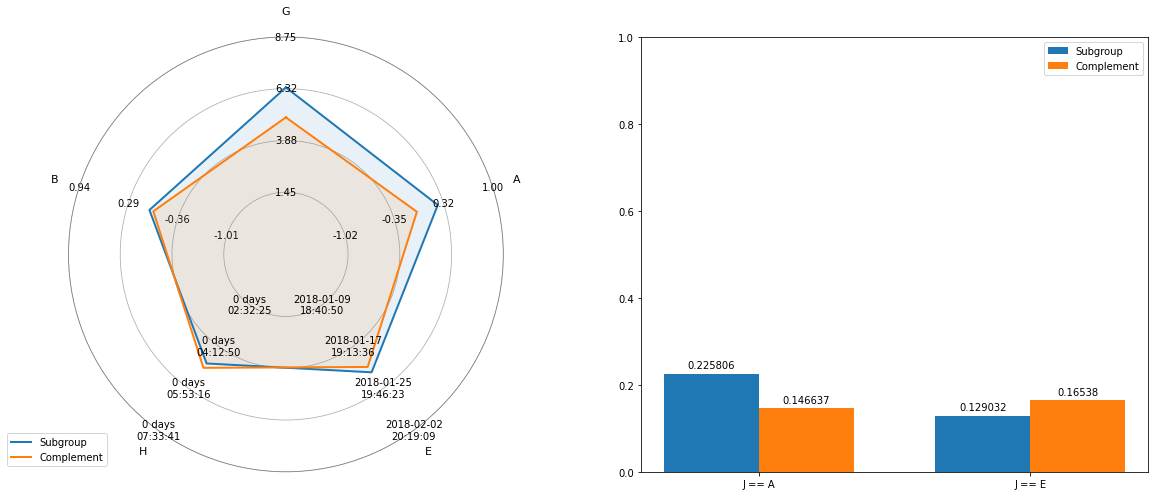

In [986]:
plt.rcParams["figure.figsize"] = (20,8)
visualise_subgroup(subgroups.subgroups[0], df2, df2)


In [954]:
tmp

,J == A,J == E
Subgroup,0.225806,0.129032
Complement,0.146637,0.165380


In [958]:
tmp.iloc[0].name

'Subgroup'

In [ ]:
pd.concat([
    df2[interesting_numeric.index.tolist()].mean(numeric_only=False),
    df2[interesting_numeric.index.tolist()].mean(numeric_only=False)
],axis=1).T.max(numeric_only=False)

In [ ]:
df2.E[0]

In [ ]:
df2.E[0].strftime('%Y-%m-%d %H:%M:%S')

In [673]:
df2.H[0].components

Components(days=0, hours=8, minutes=0, seconds=0, milliseconds=0, microseconds=0, nanoseconds=0)

In [674]:
print(*df2.H[0].components)

0 8 0 0 0 0 0


In [675]:
"{0}d {1}:{2}:{3:.2f}".format(*df2.H[0].components)

'0d 8:0:0.00'

In [676]:
dir(df2.H[0])

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__inv__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pyx_vtable__',
 '__radd__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_cython__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setstate__',
 '__setstate_cython__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_d',
 '_ensure_components',
 '_h',
 '_has_ns',
 '_m',
 '_ms',
 '_ns',
 '_repr_base',
 '_round',
 '_s',
 '_us',
 'asm8',
 'ceil',
 'components',
 'days',
 'delta',
 'floor',
 'freq',
 'is_populated',
 'isoformat',
 'max',
 'microseconds',
 'min',
 'nanoseconds',
 

In [502]:
dir(type(df2.E[0]))

['__add__',
 '__array_priority__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__radd__',
 '__reduce__',
 '__reduce_cython__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__setstate__',
 '__setstate_cython__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_date_repr',
 '_repr_base',
 '_round',
 '_short_repr',
 '_time_repr',
 'asm8',
 'astimezone',
 'ceil',
 'combine',
 'ctime',
 'date',
 'day',
 'day_name',
 'day_of_week',
 'day_of_year',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'dst',
 'floor',
 'fold',
 'freq',
 'freqstr',
 'fromisocalendar',
 'fromisoformat',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 '

In [513]:
str(df2.H[0])

'0 days 08:00:00'

In [ ]:
tst1 = df2.loc[subgroups.subgroups[0].get_indices(df2)]
tst2 = df2.drop(subgroups.subgroups[0].get_indices(df2), axis=0)

/tmp/ipykernel_21983/1880139594.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  radar_plot(pd.concat([tst1.mean(), tst2.mean()], axis=1).T.drop('H', axis=1).set_index([['sg', 'pop']]))


<PolarAxesSubplot:>

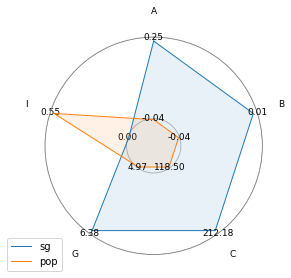

In [413]:
radar_plot(pd.concat([tst1.mean(), tst2.mean()], axis=1).T.drop('H', axis=1).set_index([['sg', 'pop']]))

In [405]:
pd.concat([tst1.mean(), tst2.mean()], axis=1).T.set_index([['sg', 'pop']])

/tmp/ipykernel_21983/3393604133.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pd.concat([tst1.mean(), tst2.mean()], axis=1).T.set_index([['sg', 'pop']])


,A,B,C,G,H,I
sg,0.24585,0.014428,212.182796,6.376344,0 days 04:53:32.903225806,0.0
pop,-0.039215,-0.036912,118.501654,4.970232,0 days 05:04:02.116868798,0.550165


/tmp/ipykernel_21983/1880139594.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  radar_plot(pd.concat([tst1.mean(), tst2.mean()], axis=1).T.drop('H', axis=1).set_index([['sg', 'pop']]))


<PolarAxesSubplot:>

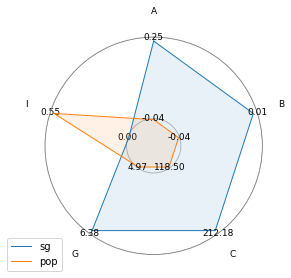

In [410]:
radar_plot(pd.concat([tst1.mean(), tst2.mean()], axis=1).T.drop('H', axis=1).set_index([['sg', 'pop']]))

In [857]:
[print(x[0]) for x in interesting_nominal.index.tolist()]

J
J
J
J
J


[None, None, None, None, None]

In [858]:
["{0} == {1}".format(*x) for x in interesting_nominal.index.tolist()]

['J == B', 'J == F', 'J == D', 'J == E', 'J == A']

In [830]:
dir(interesting_nominal.index)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__inv__',
 '__isub__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_accessors',
 '_arith_method',
 '_assert_c

In [374]:
interesting_numeric, interesting_nominal = find_interesting_columns(subgroups.subgroups[0], df2)

In [375]:
interesting_numeric = pd.DataFrame(interesting_numeric.values(), index=interesting_numeric.keys())

In [376]:
interesting_nominal = pd.DataFrame(interesting_nominal.values(), index=interesting_nominal.keys())

In [377]:
interesting_numeric

,0
A,0.283080
B,0.052515
E,0.085151
G,0.386776
H,-0.069477


In [378]:
interesting_nominal

0         1         2
J B  0.929052  0.535478  1.611901
  F  0.998494  0.574854  1.734337
  D  1.111063  0.638486  1.933419
  E  0.747654  0.397770  1.405303
  A  1.697368  1.009376  2.854297

In [379]:
interesting_numeric.iloc[interesting_numeric[0].abs().argsort()][::-1][0]

G    0.386776
A    0.283080
E    0.085151
H   -0.069477
B    0.052515
Name: 0, dtype: float64

In [380]:
max_lower = interesting_nominal.loc[interesting_nominal[1].groupby(level=0).idxmax()][1]
max_lower = max_lower.iloc[max_lower.abs().argsort()][::-1]
max_lower

J  A    1.009376
Name: 1, dtype: float64

In [347]:
min_upper = interesting_nominal.loc[interesting_nominal[2].groupby(level=0).idxmin()][2]
min_upper = min_upper[interesting_nominal.groupby(level=0).count()[2].values > 2]
min_upper = min_upper[min_upper > 0]
min_upper = (1 / min_upper)
min_upper = min_upper.iloc[min_upper.abs().argsort()][::-1]
min_upper

J  E    0.71159
Name: 2, dtype: float64

In [354]:
pd.concat([max_lower, min_upper]).sort_values(ascending=False)

J  A    1.009376
   E    0.711590
dtype: float64

In [368]:
corrected_hedges_g(pd.Series(np.random.normal(2,2, 100)), pd.Series(np.random.normal(0,2, 100)))

1.1505597688688158

In [353]:
pd.Series.sort_values

<function pandas.core.series.Series.sort_values(self, axis=0, ascending: Union[bool, int, Sequence[Union[bool, int]]] = True, inplace: bool = False, kind: str = 'quicksort', na_position: str = 'last', ignore_index: bool = False, key: Union[Callable[[ForwardRef('Series')], Union[ForwardRef('Series'), ~AnyArrayLike]], NoneType] = None)>

In [344]:
interesting_nominal.loc[interesting_nominal[2].groupby(level=0).idxmin()]

,,0,1,2
J,E,0.747654,0.39777,1.405303


In [345]:
print(subgroups.subgroups[0])

169.33 <= C AND D = foo AND I = False


In [222]:
subgroups.subgroups[0].get_rows(df2).A.mean()

0.2737

In [223]:
df2.A.mean()

-0.00764

In [181]:
df2.describe()

,A,B,C,G,H
count,1000.000000,1000.000000,1000.000000,1000.000000,1000
mean,-0.007641,0.008523,126.285000,5.336000,0 days 04:49:04.800000
std,0.963867,1.002150,72.723356,3.698213,0 days 02:35:15.288914873
min,-2.898438,-3.427517,0.000000,1.000000,0 days 01:00:00
25%,-0.709961,-0.682866,64.000000,1.000000,0 days 03:00:00
50%,-0.040741,-0.035688,125.500000,5.000000,0 days 05:00:00
75%,0.657471,0.648136,190.250000,10.000000,0 days 07:00:00
max,3.439453,3.235025,254.000000,10.000000,0 days 09:00:00


In [166]:
pd.to_numeric(df2.H).var()

8.677460756756755e+25

In [ ]:
pd.to_numeric(df2.H) - pd.to_numeric(df2.H).m

In [173]:
df2.J.name

'J'

In [182]:
df2.head()

,A,B,C,D,E,G,H,I,J
0,-0.954102,0.458282,59,bar,2018-01-01 00:00:00,5,0 days 07:00:00,False,E
1,1.475586,0.782500,33,bar,2018-01-01 01:00:00,1,0 days 09:00:00,False,F
2,-1.307617,1.559834,47,bar,2018-01-01 02:00:00,1,0 days 02:00:00,False,E
3,1.649414,0.316714,61,bar,2018-01-01 03:00:00,10,0 days 08:00:00,True,D
4,-1.316406,-0.983174,203,foo,2018-01-01 04:00:00,1,0 days 03:00:00,False,B


In [124]:
subgroups.subgroups[0].get_indices(df2)

Int64Index([  1,  12,  17,  24,  30,  33,  35,  44,  51,  93,
            ...
            896, 912, 940, 943, 944, 954, 963, 979, 988, 995],
           dtype='int64', length=123)

In [122]:
df2.drop(subgroups.subgroups[0].get_indices(df2), axis=0)

,A,B,C,D,E,G,H,I,J
0,-0.954102,0.458282,59,bar,2018-01-01 00:00:00,5,0 days 07:00:00,False,E
2,-1.307617,1.559834,47,bar,2018-01-01 02:00:00,1,0 days 02:00:00,False,E
3,1.649414,0.316714,61,bar,2018-01-01 03:00:00,10,0 days 08:00:00,True,D
4,-1.316406,-0.983174,203,foo,2018-01-01 04:00:00,1,0 days 03:00:00,False,B
5,0.470947,0.720610,53,foo,2018-01-01 05:00:00,5,0 days 08:00:00,False,E
...,...,...,...,...,...,...,...,...,...
994,0.017395,0.020144,238,foo,2018-02-11 10:00:00,10,0 days 02:00:00,True,A
996,0.377686,-0.391683,152,bar,2018-02-11 12:00:00,10,0 days 06:00:00,True,E
997,-1.096680,0.743538,172,bar,2018-02-11 13:00:00,10,0 days 05:00:00,False,D
998,0.156982,-0.218807,61,foo,2018-02-11 14:00:00,5,0 days 05:00:00,True,B


In [67]:
pd.DataFrame([{'pattern':str(x), 'mean':(conf_intervals(x, df2, "A")[0], conf_intervals(x, df2, "A")[1]), 'proportion':(conf_intervals(x, df2, "A")[2], conf_intervals(x, df2, "A")[3])} for x in subgroups.subgroups])

,pattern,mean,proportion
0,169.33 <= C AND -1.16 <= B < 0.88,"(-0.11995239257812498, 0.28203125)","(0.13695000000000002, 0.2100999999999999)"
1,D = foo,"(-0.081072998046875, 0.24033813476562496)","(0.32995, 0.4150499999999999)"
2,169.33 <= C AND 4.00 <= G < 7.00 AND -1.16 <= ...,"(0.0009136199951171886, 0.6845214843749998)","(0.038, 0.08009999999999991)"
3,D = foo AND -1.16 <= B < 0.88,"(-0.140008544921875, 0.213818359375)","(0.2179, 0.2923999999999996)"
4,I = False AND D = foo AND -1.16 <= B < 0.88,"(-0.105755615234375, 0.3838134765625)","(0.09395, 0.15414999999999987)"
5,7.00 <= G AND D = foo,"(-0.09971008300781249, 0.45479736328125)","(0.081, 0.1450999999999999)"
6,169.33 <= C AND D = foo AND -1.16 <= B < 0.88,"(-0.16707153320312498, 0.5359863281249999)","(0.04980000000000001, 0.10104999999999996)"
7,169.33 <= C AND 0 days 03:40:00 <= H < 0 days ...,"(-0.054348754882812496, 0.6795410156249997)","(0.038, 0.0760999999999999)"
8,169.33 <= C AND 4.00 <= G < 7.00,"(-0.1628662109375, 0.451806640625)","(0.057, 0.11514999999999986)"
9,I = False AND D = foo,"(-0.0927032470703125, 0.31394042968749997)","(0.14295, 0.23204999999999998)"


In [87]:
confidence_intervals(subgroups.subgroups[0], df2, "A")

(-0.11302185058593749, 0.3794189453125, 0.2310810810810811, 0.3695195195195194)

In [91]:
subgroups.to_df().merge(confidence_intervals(subgroups, df2, "A"), on="pattern")

,pattern,target_quantity,size,quality,target_lower,target_upper,proportion_lower,proportion_upper
0,169.33 <= C AND -1.16 <= B < 0.88,0.137112,226.0,30.024572,-0.202618,0.417419,0.237087,0.357508
1,D = foo,0.061408,499.0,28.517169,-0.075980,0.228729,0.578679,0.783784
2,169.33 <= C AND 4.00 <= G < 7.00 AND -1.16 <= ...,0.328779,78.0,25.312470,-0.016953,0.759180,0.063063,0.153453
3,D = foo AND -1.16 <= B < 0.88,0.072436,341.0,23.248092,-0.131677,0.259863,0.369369,0.543694
4,I = False AND D = foo AND -1.16 <= B < 0.88,0.143557,165.0,22.984124,-0.142010,0.505859,0.153153,0.294444
5,7.00 <= G AND D = foo,0.151740,149.0,21.974631,-0.151190,0.428955,0.147147,0.270420
6,169.33 <= C AND D = foo AND -1.16 <= B < 0.88,0.216036,99.0,20.965889,-0.186017,0.612354,0.089940,0.195796
7,169.33 <= C AND 0 days 03:40:00 <= H < 0 days ...,0.279211,75.0,20.621315,-0.086093,0.670410,0.063063,0.147297
8,169.33 <= C AND 4.00 <= G < 7.00,0.187178,107.0,19.572299,-0.210443,0.564478,0.090090,0.204354
9,I = False AND D = foo,0.079684,245.0,18.478832,-0.167639,0.367542,0.248949,0.405556


In [49]:
np.quantile(np.random.randint(1,100, 1000), 0.95)

94.0

In [146]:
len(df2.replace(df2.iloc[0,:], np.NaN).I) - pd.isna(df2.replace(df2.iloc[0,:], np.NaN).I).sum()

496

In [147]:
df2.replace(df2.iloc[0,:], np.NaN).I.count()

496

0       NaN
1       NaN
2       NaN
3      True
4       NaN
       ... 
995     NaN
996    True
997     NaN
998    True
999    True
Name: I, Length: 1000, dtype: object

In [132]:
df2.replace(df2.iloc[0,:], np.NaN)

,A,B,C,D,E,G,H,I,J
0,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN
1,1.475586,0.782500,33.0,NaN,2018-01-01 01:00:00,1.0,0 days 09:00:00,NaN,F
2,-1.307617,1.559834,47.0,NaN,2018-01-01 02:00:00,1.0,0 days 02:00:00,NaN,NaN
3,1.649414,0.316714,61.0,NaN,2018-01-01 03:00:00,10.0,0 days 08:00:00,True,D
4,-1.316406,-0.983174,203.0,foo,2018-01-01 04:00:00,1.0,0 days 03:00:00,NaN,B
...,...,...,...,...,...,...,...,...,...
995,1.163086,-0.084587,103.0,foo,2018-02-11 11:00:00,NaN,NaT,NaN,F
996,0.377686,-0.391683,152.0,NaN,2018-02-11 12:00:00,10.0,0 days 06:00:00,True,NaN
997,-1.096680,0.743538,172.0,NaN,2018-02-11 13:00:00,10.0,0 days 05:00:00,NaN,D
998,0.156982,-0.218807,61.0,foo,2018-02-11 14:00:00,NaN,0 days 05:00:00,True,B


In [137]:
df2.D.eq('bar') & df2.I

0      False
1      False
2      False
3       True
4      False
       ...  
995    False
996     True
997    False
998    False
999     True
Length: 1000, dtype: bool

In [138]:
df2.D.eq('bar').and(df2.I)

SyntaxError: invalid syntax (1447727390.py, line 1)

In [129]:
df2.replace(df2.iloc[0,:], np.NaN).I

0       NaN
1       NaN
2       NaN
3      True
4       NaN
       ... 
995     NaN
996    True
997     NaN
998    True
999    True
Name: I, Length: 1000, dtype: object

In [130]:
df2.replace(df2.iloc[0,:], np.NaN).I == True

0      False
1      False
2      False
3       True
4      False
       ...  
995    False
996     True
997    False
998     True
999     True
Name: I, Length: 1000, dtype: bool

In [131]:
df2.replace(df2.iloc[0,:], np.NaN).I == False

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: I, Length: 1000, dtype: bool

0     -0.083130
1      0.453369
2      0.326660
3     -1.523438
4      0.784180
         ...   
995    0.492432
996   -0.880371
997    0.774902
998   -0.189331
999   -0.040710
Name: A, Length: 1000, dtype: float16

In [28]:
df2.replace(df2.iloc[0,:], np.NaN).loc[:,'D'].count()

499

In [29]:
df2.loc[:,'D'].count()

1000

In [31]:
df2.replace(df2.iloc[0,:], np.NaN).loc[:,'I'].eq(False).sum()

493